In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
java_dataset = pd.read_csv('/content/drive/MyDrive/machine learning/Datasets/merged dataset_FE_LM_GC_DC_class balancer.csv', sep=',', encoding='iso-8859-1')

In [4]:
csharp_dataset = pd.read_csv('/content/drive/MyDrive/machine learning/Datasets/GeneratedDataset_CSharp.csv', sep=';', encoding='iso-8859-1')
csharp_dataset = csharp_dataset[csharp_dataset.DataSet == "large_class"]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## **PREDICTOR AND TARGET ATTRIBUTES**

In [6]:
# Java Dataset
#predictors_chi_original = df.iloc[:, [10,11,13,14,15,17,19,21,22,23,25,30,31,33,34,35,37,40,44,54,60,61,62,63,64]].values
java_dataset_features = [10,11,13,14,15,17,19,21,22,23,25,30,31,33,34,35,37,40,44,54,60,61,62,63,64]
java_binary_predictors = java_dataset.iloc[:, java_dataset_features].values
java_multiclass_predictors = java_dataset.iloc[:, java_dataset_features].values
java_binary_targets = java_dataset.iloc[:, 5].values
java_multiclass_targets = java_dataset.iloc[:, 7].values

# CSharp Datasets
csharp_dataset_features = [8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,26,28,30,34,36,37,38,39,40]
csharp_binary_predictors = csharp_dataset.iloc[:, csharp_dataset_features].values
csharp_multiclass_predictors = csharp_dataset.iloc[:, csharp_dataset_features].values
csharp_binary_targets = csharp_dataset.iloc[:, 5].values
csharp_multiclass_targets = csharp_dataset.iloc[:, 7].values

# **Binary Code Smell Detection**

In [ ]:
pip install seaborn

In [7]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 19.7 MB/s eta 0:00:00


## **No Oversampling**

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       175
           1       0.84      0.87      0.85        61

    accuracy                           0.92       236
   macro avg       0.90      0.91      0.90       236
weighted avg       0.92      0.92      0.92       236



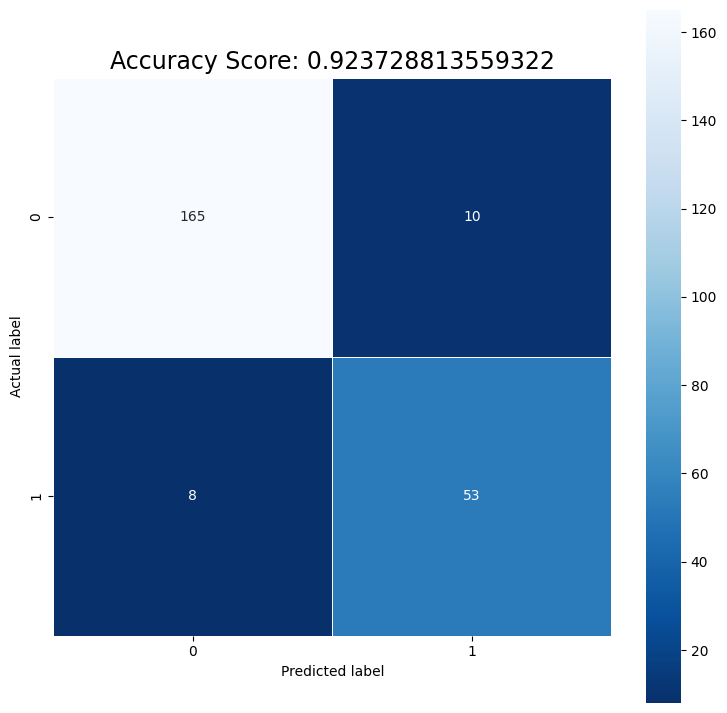

In [ ]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, objective='MultiClass',
                              learning_rate=0.01, leaf_estimation_method='Newton', l2_leaf_reg=6, iterations=454, grow_policy='Lossguide',
                              feature_border_type='UniformAndQuantiles', depth=5, border_count=192, bootstrap_type='MVS', auto_class_weights= 'Balanced')

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **BorderlineSMOTE**

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       175
           1       0.81      0.90      0.85        61

    accuracy                           0.92       236
   macro avg       0.89      0.91      0.90       236
weighted avg       0.92      0.92      0.92       236



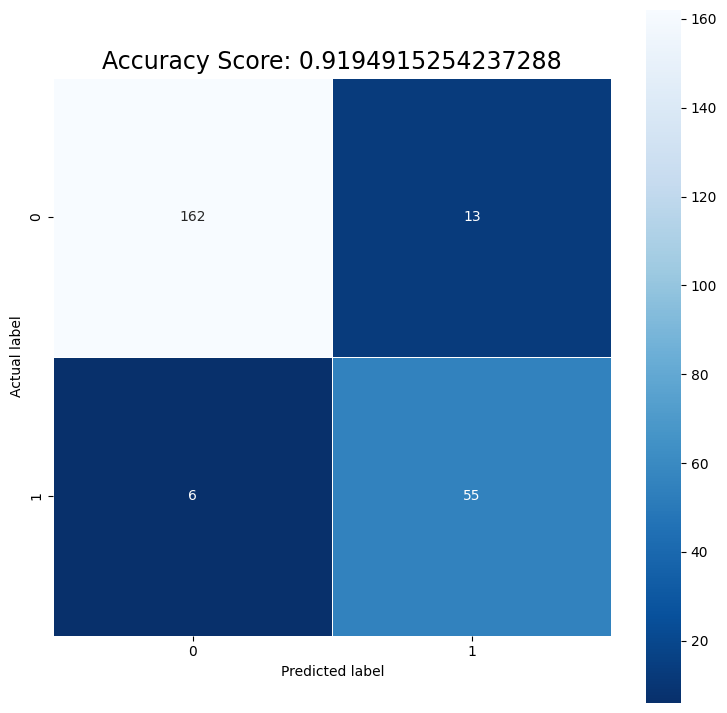

In [8]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# OverSampling
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42)
x_train_csharp_binary, y_train_csharp_binary = sm.fit_resample(x_train_csharp_binary, y_train_csharp_binary)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, objective='MultiClass',
                              learning_rate=0.01, leaf_estimation_method='Newton', l2_leaf_reg=6, iterations=454, grow_policy='Lossguide',
                              feature_border_type='UniformAndQuantiles', depth=5, border_count=192, bootstrap_type='MVS', auto_class_weights= 'Balanced')

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       175
           1       0.83      0.90      0.87        61

    accuracy                           0.93       236
   macro avg       0.90      0.92      0.91       236
weighted avg       0.93      0.93      0.93       236



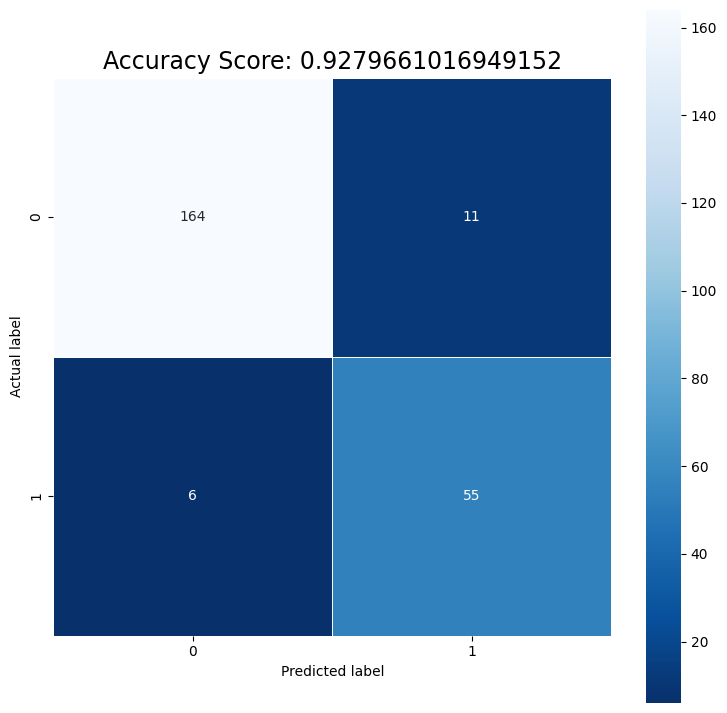

In [9]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# OverSampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train_csharp_binary, y_train_csharp_binary = sm.fit_resample(x_train_csharp_binary, y_train_csharp_binary)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, objective='MultiClass',
                              learning_rate=0.01, leaf_estimation_method='Newton', l2_leaf_reg=6, iterations=454, grow_policy='Lossguide',
                              feature_border_type='UniformAndQuantiles', depth=5, border_count=192, bootstrap_type='MVS', auto_class_weights= 'Balanced')

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **Exclude instances of no-smell from the training and test sets**


In [ ]:
x_test_multiclass, y_test_multiclass = x_test_csharp_multiclass, y_test_csharp_multiclass

# Find unique classes
unique_classes = np.unique(y_test_multiclass)

# Count the number of classes
number_classes = len(unique_classes)

if (number_classes > 3):

  x_train_multiclass, y_train_multiclass = x_train_multiclass_combined, y_train_multiclass_combined

  finish = False
  while (finish == False):
    try:
      max = x_train_multiclass.shape[0]
      # Exclude instances of no-smell from the training set (targets)
      for i in range(0, max):
        if (y_train_multiclass[i] == 0):
          y_train_multiclass = np.delete(y_train_multiclass, i, axis = 0)
          x_train_multiclass = np.delete(x_train_multiclass, i, axis = 0)
          i = 0
          max = max - 1
      finish = True
      print("The deletion is over in the y_train set!")
    except:
      finish == False

  finish = False
  while (finish == False):
    try:
      max = x_test_multiclass.shape[0]
      # Exclude instances of no-smell from the test set (predictors)
      for i in range(0, max):
        if (y_test_multiclass[i] == 0):
          y_test_multiclass = np.delete(y_test_multiclass, i, axis = 0)
          x_test_multiclass = np.delete(x_test_multiclass, i, axis = 0)
          i = 0
          max = max - 1
      finish = True
      print("The deletion is over in the x_train set!")
    except:
      finish = False

  # Original mapping -> Remapping
  mapping = {1.0: 0.0, 2.0: 1.0, 3.0: 2.0, 4.0: 3.0, 5.0: 4.0, 6.0: 5.0, 7.0: 6.0, 8.0: 7.0, 9.0: 8.0, 10.0: 9.0, 11.0: 10.0, 12.0: 11.0}

  y_train_multiclass = np.array([mapping[label] for label in y_train_multiclass])
  y_test_multiclass = np.array([mapping[label] for label in y_test_multiclass])
  print("Prepare training and test set for applying XGBoost")

The deletion is over in the y_train set!
The deletion is over in the x_train set!
Prepare training and test set for applying XGBoost


# **Code Smell Severity Classification with three ensemble method**


# **RANDOM FOREST**

# **Oversampling BorderlineSMOTE**

In [ ]:
pip install imbalanced-learn

# **Randomized**

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         9.0       0.82      0.91      0.86        34
        10.0       0.65      0.55      0.59        20
        11.0       0.75      0.43      0.55         7

    accuracy                           0.74        61
   macro avg       0.44      0.38      0.40        61
weighted avg       0.75      0.74      0.74        61



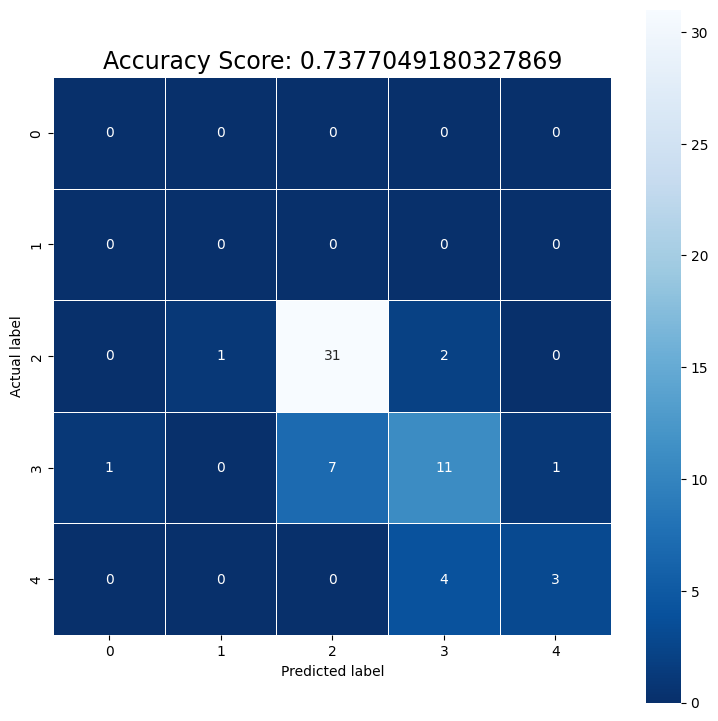

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=970, min_samples_split=7, min_samples_leaf=3, max_features=None, max_depth=6,
                                    criterion='log_loss', bootstrap=True)

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         9.0       0.82      0.97      0.89        34
        10.0       0.71      0.60      0.65        20
        11.0       1.00      0.43      0.60         7

    accuracy                           0.79        61
   macro avg       0.63      0.50      0.54        61
weighted avg       0.81      0.79      0.78        61



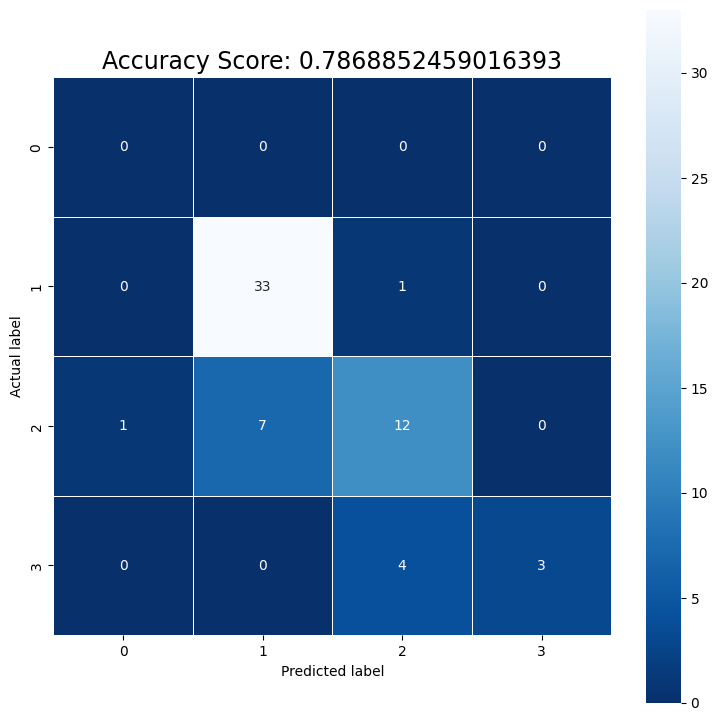

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=524, min_samples_split=12, min_samples_leaf=4, max_features='sqrt', max_depth=13,
                                    criterion='entropy', bootstrap=False)

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         9.0       0.82      0.97      0.89        34
        10.0       0.71      0.60      0.65        20
        11.0       1.00      0.43      0.60         7

    accuracy                           0.79        61
   macro avg       0.63      0.50      0.54        61
weighted avg       0.81      0.79      0.78        61



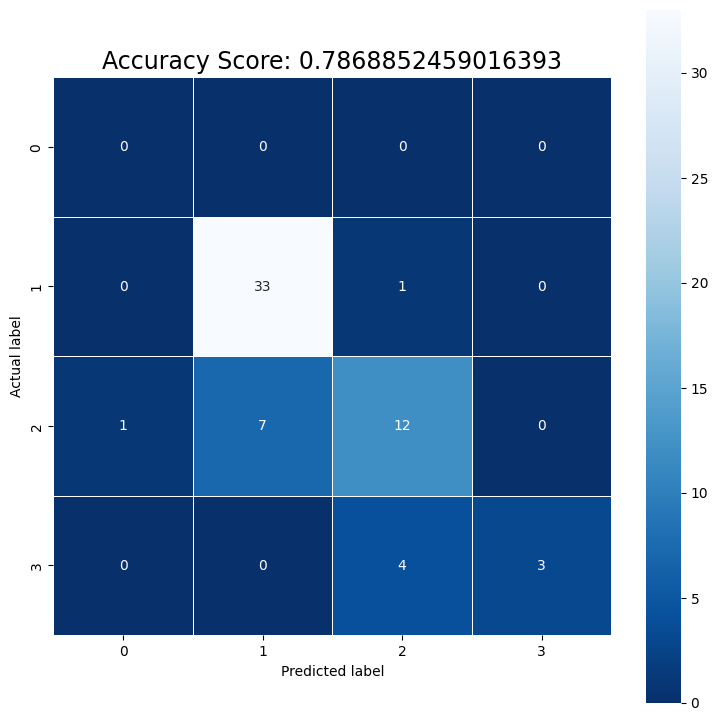

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=118, min_samples_split=12, min_samples_leaf= 3, max_features='sqrt', max_depth=9,
                                    criterion='gini', bootstrap=False)

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **EXTREME GRADIENTE BOOSTING (XGBOOST)**

# **Randomized**

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         9.0       0.85      0.97      0.90        34
        10.0       0.73      0.55      0.63        20
        11.0       0.67      0.57      0.62         7

    accuracy                           0.79        61
   macro avg       0.56      0.52      0.54        61
weighted avg       0.79      0.79      0.78        61



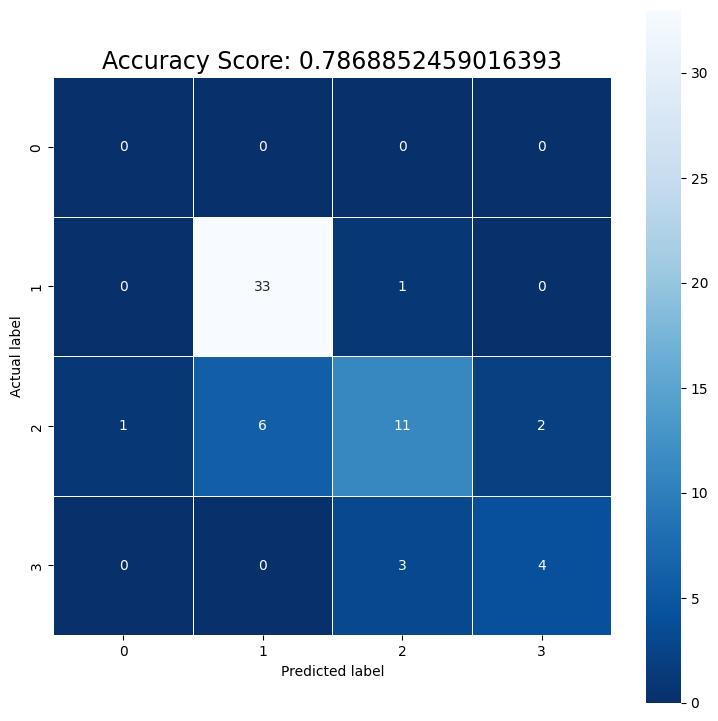

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='approx', objective='multi:softmax', n_estimators=420, max_depth=5,
                           learning_rate=0.5, grow_policy='lossguide', booster='gbtree')

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         9.0       0.84      0.94      0.89        34
        10.0       0.72      0.65      0.68        20
        11.0       1.00      0.57      0.73         7

    accuracy                           0.80        61
   macro avg       0.64      0.54      0.58        61
weighted avg       0.82      0.80      0.80        61



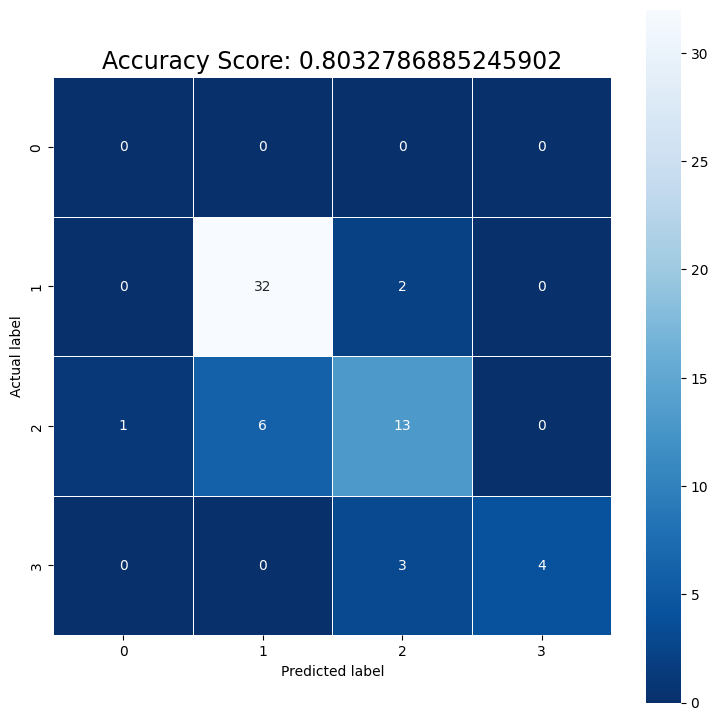

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='hist', objective='multi:softmax', n_estimators=406, max_depth=3,
                           learning_rate=0.3310344827586207, grow_policy='lossguide', booster='gbtree')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         9.0       0.86      0.88      0.87        34
        10.0       0.67      0.70      0.68        20
        11.0       1.00      0.57      0.73         7

    accuracy                           0.79        61
   macro avg       0.63      0.54      0.57        61
weighted avg       0.81      0.79      0.79        61



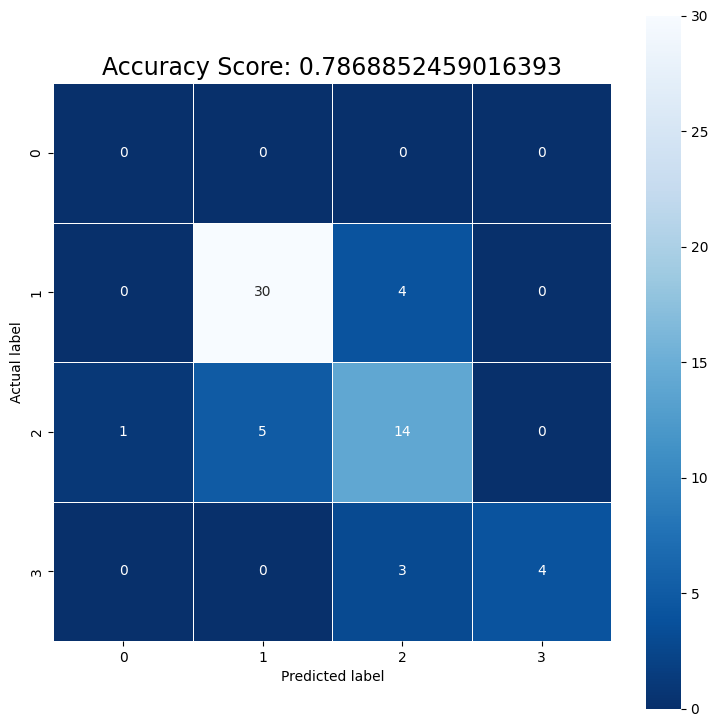

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='approx', objective='multi:softprob', n_estimators=586, max_depth=5,
                           learning_rate=0.5, grow_policy='lossguide', booster='dart')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **CATEGORICAL BOOSTING (CATBOOST)**

In [ ]:
pip install catboost

# **Randomized**

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         9.0       0.89      0.97      0.93        34
        10.0       0.78      0.70      0.74        20
        11.0       0.80      0.57      0.67         7

    accuracy                           0.84        61
   macro avg       0.62      0.56      0.58        61
weighted avg       0.84      0.84      0.84        61



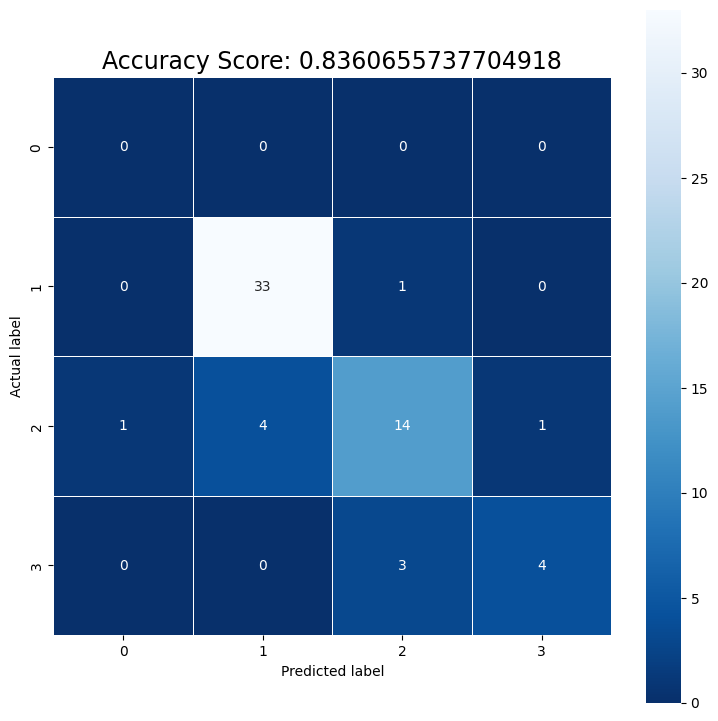

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.16206896551724137, leaf_estimation_method='Newton', l2_leaf_reg=7, iterations=592, grow_policy='Lossguide',
                                feature_border_type='Uniform', depth=6, border_count=192, bootstrap_type='MVS', auto_class_weights='Balanced')

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         9.0       0.82      0.97      0.89        34
        10.0       0.69      0.55      0.61        20
        11.0       0.75      0.43      0.55         7

    accuracy                           0.77        61
   macro avg       0.57      0.49      0.51        61
weighted avg       0.77      0.77      0.76        61



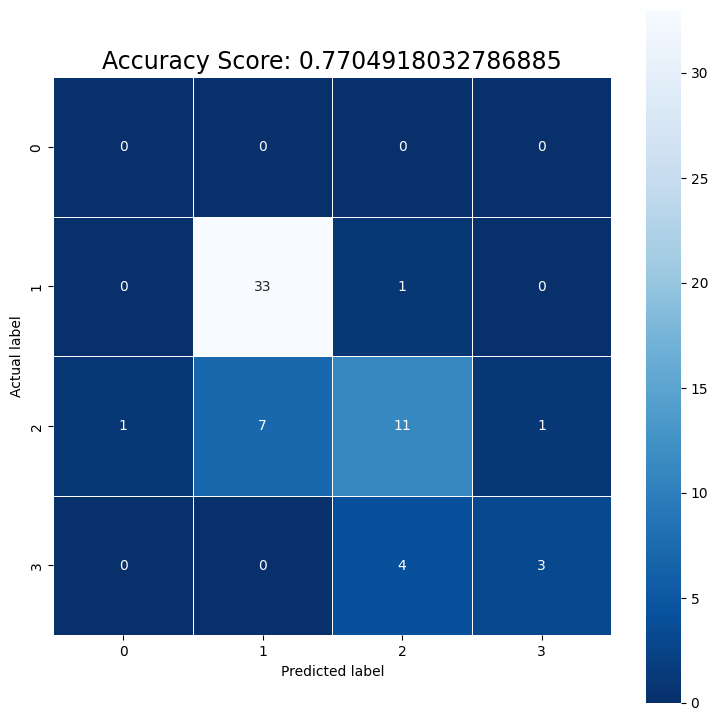

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.3310344827586207, leaf_estimation_method='Newton', l2_leaf_reg=6, iterations=734, grow_policy='Depthwise',
                                feature_border_type='GreedyLogSum', depth=15, border_count=96, bootstrap_type='Bayesian', auto_class_weights='SqrtBalanced')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00         0
         9.0       0.87      0.97      0.92        34
        10.0       0.78      0.70      0.74        20
        11.0       1.00      0.57      0.73         7

    accuracy                           0.84        61
   macro avg       0.66      0.56      0.60        61
weighted avg       0.85      0.84      0.84        61



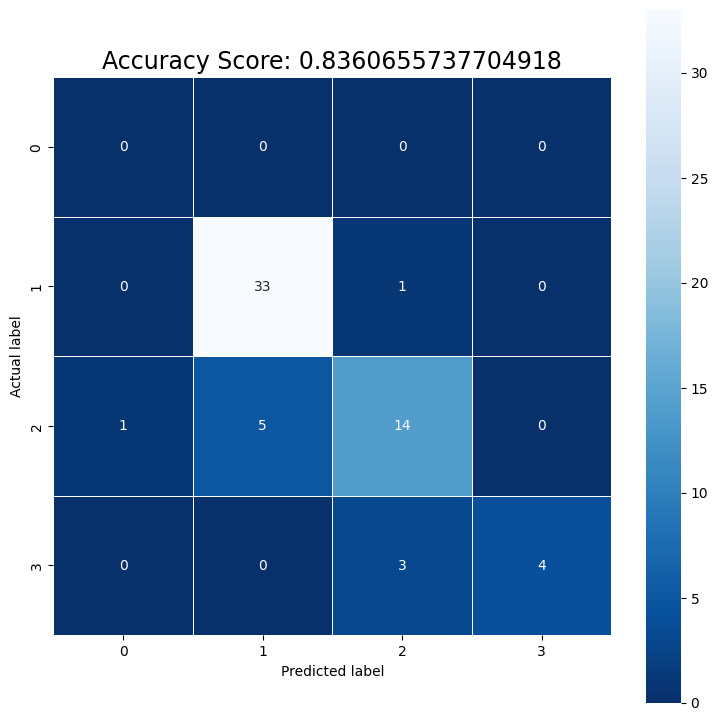

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.07758620689655171, leaf_estimation_method='Gradient', l2_leaf_reg=8, iterations=548, grow_policy='Depthwise',
                                feature_border_type='GreedyLogSum', depth=6, border_count=208, bootstrap_type='Bayesian', auto_class_weights='Balanced')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()